In [19]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.io
from sklearn.feature_selection import mutual_info_regression

from tqdm import tqdm

sns.set_style("white")

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})


In [3]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        u = self.model(self.X)

        du_dX = torch.autograd.grad(inputs=self.X, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(inputs=self.X, outputs=du_dX, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0][:, 0]
#         print(u.shape, du_dt.shape, du_dx.shape, du_dxx.shape)
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

# Training

In [5]:
net = Net()
net.train()

/Users/manjunathshettar/miniconda3/envs/torch/lib/python3.9/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682406570856/work/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.11159881949424744
200 0.09033466130495071
300 0.07912095636129379
400 0.06817461550235748
500 0.058855198323726654
600 0.04227108508348465
700 0.030413636937737465
800 0.025241892784833908
900 0.022156868129968643
1000 0.017338309437036514
1100 0.00990460067987442
1200 0.0063912272453308105
1300 0.004240062087774277
1400 0.0028155092149972916
1500 0.001647725235670805
1600 0.000889511255081743
1700 0.0006497539579868317
1800 0.0005131267826072872
1900 0.0004441082419361919
2000 0.00036008559982292354
2100 0.00031338143162429333
2200 0.00025386150809936225
2300 0.0002194289118051529
2400 0.0001912593434099108
2500 0.00016697200771886855
2600 0.0001518911449238658
2700 0.0001346153294434771
2800 0.0001237157266587019
2900 0.00011393137538107112
3000 0.00010597578511806205
3100 9.938258153852075e-05
3200 9.08805086510256e-05
3300 8.277406595880166e-05
3400 7.600370736327022e-05
3500 7.049359555821866e-05
3600 6.554976425832137e-05
3700 6.152655987534672e-05
3800 5.583864913205616e-0

# Evaluation

In [6]:
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [7]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

<Axes: >

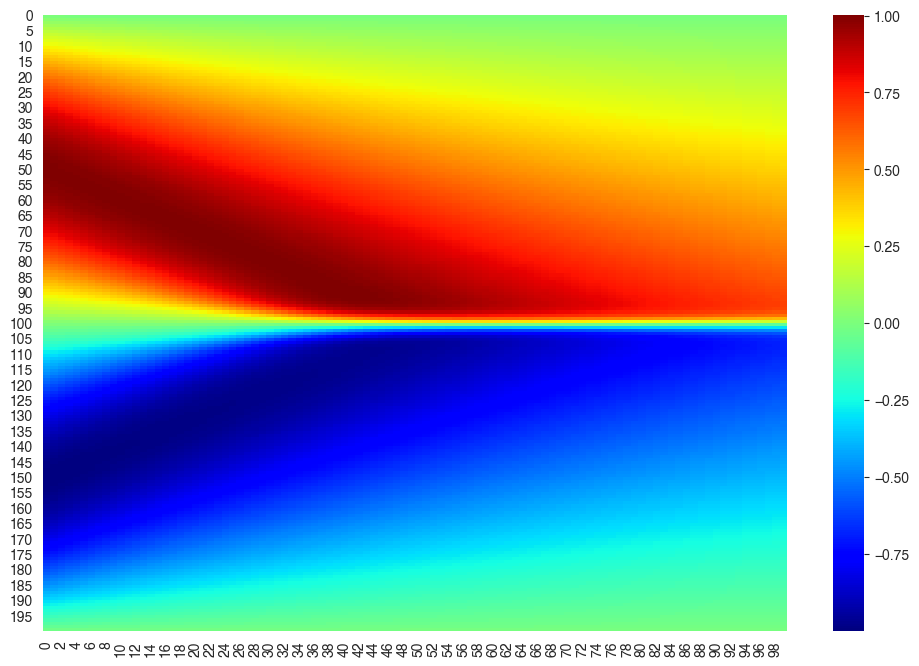

In [20]:
sns.heatmap(y_pred, cmap='jet')

# Save Result

In [21]:
mat = {'v': y_pred}
scipy.io.savemat('burgers_pinn.mat', mat)